# IF YOU RUN THIS PAGE FOR THE SECOND TIME : 

# START HERE

# Are you on PC or MAC? pc = 0, mac = 1

In [2]:
computer = 0
#! source activate tensorflow

# Librairies

In [3]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import pandas_datareader.data as web
import datetime
import pandas as pd
import os
import csv
import glob as glob
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from time import time

matplotlib.rcParams[ 'figure.figsize' ] = ( 14, 6 )

In [4]:
# Comprehensive way to set the path to Data directory

ROOTPATH = os.getcwd()

if not(ROOTPATH[-4:] == 'Data'):
    path = os.path.join(ROOTPATH, 'Data')
else:
    path = ROOTPATH

# Importing the data

In [5]:
if computer == 0:
    with open('IBB_holdings.csv', 'r') as csvfile:
        file = csv.reader(csvfile,delimiter=' ')
        c=0
        list_tickers=[]
        for row in file:
            if c>=11:
                list_tickers.append(row[0].split(',')[0])
            c+=1

if computer == 1:
    with open('IBB_holdings.csv', 'r', encoding ='mac_roman') as csvfile:
        file = csv.reader(csvfile,delimiter=' ')
        c=0
        list_tickers=[]
        for row in file:
            if c>=11:
                list_tickers.append(row[0].split(',')[0])
            c+=1            

list_tickers.sort()
list_tickers.pop()
list_tickers.remove("BLKFDS")
list_tickers.remove("USD")
list_tickers.remove("SNDX")

In [6]:
nb_tickers = len(list_tickers)
list_dataframes=[]


allFiles = glob.glob(path + "/csv" + "*.csv")
i = 0

if computer == 0:
    for file_ in allFiles:
        with open(file_, 'r') as csvfile:
            list_dataframes.append(pd.read_csv(csvfile, index_col=None, header=0))
            i+=1

if computer == 1:
    for file_ in allFiles:
        with open(file_, 'r', encoding ='mac_roman') as csvfile:
            list_dataframes.append(pd.read_csv(csvfile, index_col=None, header=0))
            i += 1
            
num_files = i
            
            
maxi = 0
length = 0
compt = 0
j = 0

for df in list_dataframes:
    if len(df)>maxi:
        maxi = len(df['Adj Close'])

data = np.array([np.zeros(maxi)]*(num_files))
data_normalized = np.array([np.zeros(maxi)]*(num_files))


for df in list_dataframes:
    arr = np.array(df['Adj Close'])
    if len(arr) == maxi and not df['Adj Close'].isnull().values.any(): 
        data[j] = arr
        minimum = np.min(arr)
        maximum = np.max(arr)
        arr = (arr - minimum) / (maximum - minimum)
        data_normalized[j] = arr
        j += 1
    else :
        compt += 1            
    

    
data = data[:-compt]  
data_normalized = data_normalized[:-compt]  


idx = np.arange(0 , len(data))
np.random.shuffle(idx)
data_shuffle = [data_normalized[ i] for i in idx]



train_set = data_shuffle[:-50]
test_set = data_shuffle[-50:-25]
validation_set = data_shuffle[-25:]


# 9) Set up Tensorboard

In [7]:
def variable_summary(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

# 10) Set up the autoencoder

In [8]:
def next_batch(batch_size, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.array(data_shuffle), np.array(labels_shuffle)

# Parameters

In [9]:
# Training Parameters
learning_rate = 0.001
num_steps = 300
batch_size = 10
lambd = 0.1

display_step = 100

# Network Parameters 

num_hidden_1 = 250 # 1st layer num features
num_input = 503 # 503 days considered

date = str(int(time()))

logs_path = '/tmp/tensorflow_logs/autoencoder1/'+date+'/'


# Placeholders

In [10]:
X = tf.placeholder("float", [None, num_input])
learning = tf.placeholder("float")
keep_prob = tf.placeholder(tf.float32) #gateway for dropout

# Weights and biases

In [11]:
weights = {
    'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden_1],mean=0.0,
    stddev=1.0/np.sqrt(num_input))),
    'decoder_h1': tf.Variable(tf.random_normal([num_hidden_1, num_input],mean=0.0,
    stddev=1.0/np.sqrt(num_hidden_1)))
}
biases = {
    'encoder_b1': tf.Variable(tf.zeros([num_hidden_1])),
    'decoder_b1': tf.Variable(tf.zeros([num_input])),
}

# Building layers

In [12]:
# Building the encoder
def encoder(x, layer_name='encoder'):
    # Just 1 layer
    with tf.name_scope(layer_name):
        with tf.name_scope('weights'):
            weights_e = weights['encoder_h1']
            variable_summary(weights_e)
        with tf.name_scope('biases'):
            biases_e = biases['encoder_b1']
            variable_summary(biases_e)
        with tf.name_scope('Wx_plus_b'):
            preactivate = tf.add(tf.matmul(x, weights_e), biases_e)
            tf.summary.histogram('pre_activations', preactivate)
        with tf.name_scope('batch_norm'):
            bn = tf.layers.batch_normalization(preactivate, training = True)
            tf.summary.histogram('batch_nomralization', bn)
        activations = tf.nn.relu(bn)
        tf.summary.histogram('activations', activations)
        return activations


# Building the decoder
def decoder(x,  layer_name='decoder'):
    with tf.name_scope(layer_name):
        with tf.name_scope('weights'):
            weights_d = weights['decoder_h1']
            variable_summary(weights_d)
        with tf.name_scope('biases'):
            biases_d = biases['decoder_b1']
            variable_summary(biases_d)
        with tf.name_scope('Wx_plus_b'):
            preactivate = tf.add(tf.matmul(x, weights_d), biases_d)
            tf.summary.histogram('pre_activations', preactivate)
        with tf.name_scope('batch_norm'):
            bn = tf.layers.batch_normalization(preactivate, training = True)
            tf.summary.histogram('batch_normalization', bn)
        activations = tf.nn.relu(bn)
        activations = tf.nn.relu(preactivate)
        tf.summary.histogram('activations', activations)
        return activations

In [13]:
# Construct model
encoder_op = encoder(X)

with tf.name_scope('dropout'):
    tf.summary.scalar('dropout_keep_probability', keep_prob)
    dropped = tf.nn.dropout(encoder_op, keep_prob)

decoder_op = decoder(dropped)

# Prediction step

In [14]:
# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
#mse = tf.pow(y_true - y_pred, 2)
#loss = tf.reduce_sum(mse)

mse = tf.squared_difference(y_pred, y_true)

# Loss

In [15]:
regularizer = tf.nn.l2_loss(weights['encoder_h1'])
regularizer += tf.nn.l2_loss(weights['decoder_h1'])
#loss = tf.reduce_mean(mse + lambd * regularizer)
loss = tf.reduce_sum(mse + lambd * regularizer)/(num_input * batch_size * 2)

#Replace learning_rate by learning to get an adaptative learning rate
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning).minimize(loss)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Summary events for TensorBoard

In [16]:
# Add the 'loss' event
tf.summary.scalar("loss", loss)

# Add the 'accuracy' event
# tf.summary.scalar("accuracy", acc)

# Merge all summaries into a single op
merged_summary_op = tf.summary.merge_all()

# 10) Train the autoencoder

In [17]:
# Start Training
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(init)

costs = []

init_learn =  0.001
inter_learn = 0.0001
final_learn = 0.00001

learn = init_learn

# Prepare the summary file for TensorBoard
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

dropout = .9

start_time = time()

# Training
for i in range(1, num_steps+1):
    # Prepare Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    total_batch = int(len(train_set)/batch_size)
    
    for j in range(total_batch):
        mini_batch_x, _ = next_batch(batch_size,train_set,train_set)

        # Run optimization op (backprop) and cost op (to get loss value)
        if i==2000:
            learn = inter_learn
        elif i==4000:
            learn = final_learn

        _, l, summary = sess.run([optimizer, loss, merged_summary_op], 
                    feed_dict={X: mini_batch_x, learning : learn,  keep_prob : dropout})
        costs.append(l)
        
    # Write on the log file the datas for TensorBoard / First: summary, Second: overall step
    summary_writer.add_summary(summary, i)
    
    # Display logs per step
    if i % display_step == 0 or i == 1:
        print('Step %i: Minibatch Loss: %f' % (i, l))
        curr_time = time()
        elapsed_time = curr_time-start_time
        print('Estimated remaining time = ', elapsed_time / i * (num_steps-i),'s\n')

Step 1: Minibatch Loss: 14.131540
Estimated remaining time =  102.77718663215637 s

Step 100: Minibatch Loss: 0.022564
Estimated remaining time =  27.537574291229248 s

Step 200: Minibatch Loss: 0.022931
Estimated remaining time =  13.735623717308043 s

Step 300: Minibatch Loss: 0.026008
Estimated remaining time =  0.0 s



In [17]:
# Testing
# Encode and decode images from test set and visualize their reconstruction.
n = 10

for i in range(n):
    # MNIST test set
    batch_x, _ = next_batch(batch_size,test_set,test_set)
    # Encode and decode the digit image)
    l , p = sess.run([loss,y_pred] , feed_dict={X: batch_x,  keep_prob : 1})
    print('Minibatch Loss: ', l)    

Minibatch Loss:  0.0190372
Minibatch Loss:  0.0187
Minibatch Loss:  0.0199572
Minibatch Loss:  0.0183971
Minibatch Loss:  0.0215426
Minibatch Loss:  0.0194591
Minibatch Loss:  0.0194525
Minibatch Loss:  0.0172299
Minibatch Loss:  0.0190758
Minibatch Loss:  0.0181954


# 11) Exporting

In [18]:
print("Run the command line:\n" \
          "--> tensorboard --logdir=/tmp/tensorflow_logs/autoencoder1/"+date+"/" \
          "\nThen open http://0.0.0.0:6006/ into your web browser\n\n")
print("Or Run the command line:\n" \
          "--> python -m tensorboard.main --logdir=C:\\tmp\\tensorflow_logs\\autoencoder1\\"+date+"\\" \
          "\nThen open http://desktop-p6qj80l:6006/ into your web browser, or anything the command tells you to type\n\n")

Run the command line:
--> tensorboard --logdir=/tmp/tensorflow_logs/autoencoder1/1519148138/
Then open http://0.0.0.0:6006/ into your web browser


Or Run the command line:
--> python -m tensorboard.main --logdir=C:\tmp\tensorflow_logs\autoencoder1\1519148138\
Then open http://desktop-p6qj80l:6006/ into your web browser, or anything the command tells you to type




In [19]:
#! tensorboard --logdir=/tmp/tensorflow_logs/autoencoder1/ 

# 12) Checking prediction

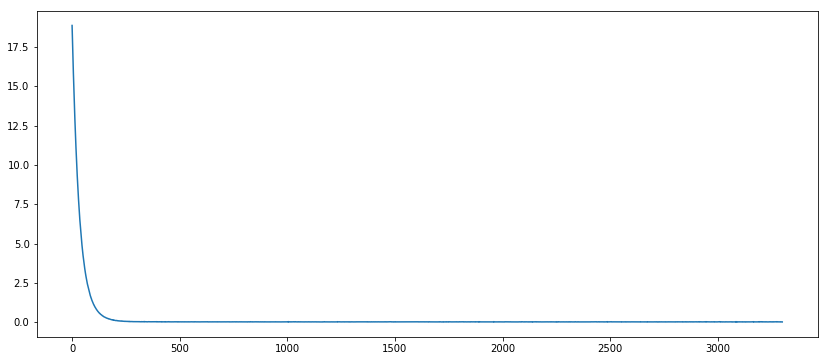

In [20]:
plt.plot(costs)
plt.show()

# Plotting

In [21]:
def denormalize(p,batch):
    batch_size = len(batch)
    unnormalized_p = {}
    for j in range(batch_size):
        true = batch[j]
        index = -1
        i = 0
        while index < 0:
            if data_normalized[i][0] - true[0] == 0:
                index = i
            i += 1

        minimum = np.min(data[index])
        maximum = np.max(data[index])

        pred = p[j] * (maximum - minimum) + minimum
        unnormalized_p[index] = pred
    return unnormalized_p
    
unnormalized_p = denormalize(p, batch_x)

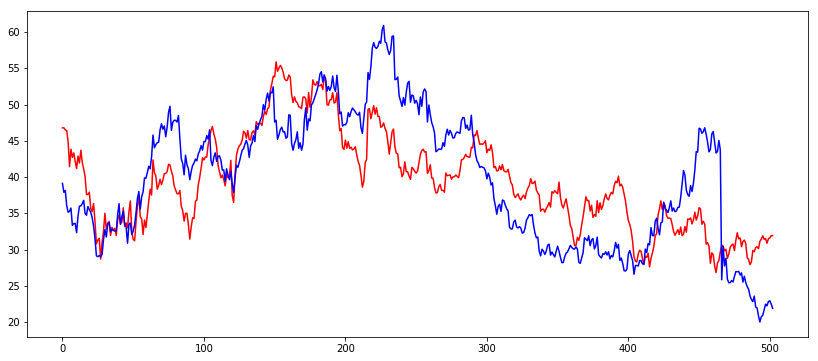

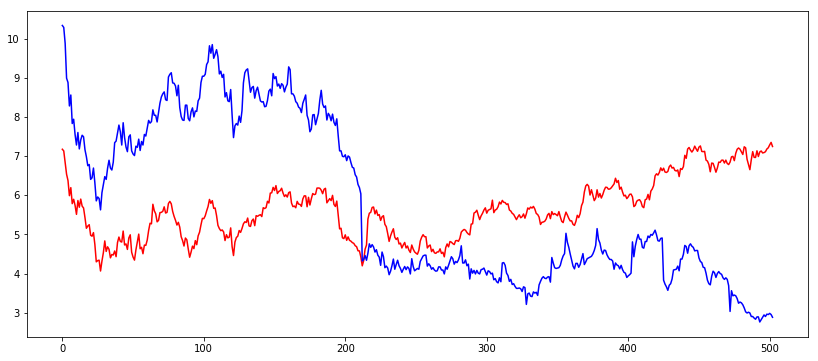

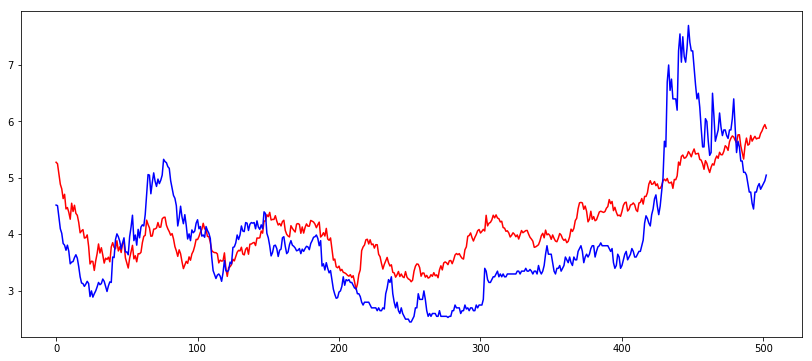

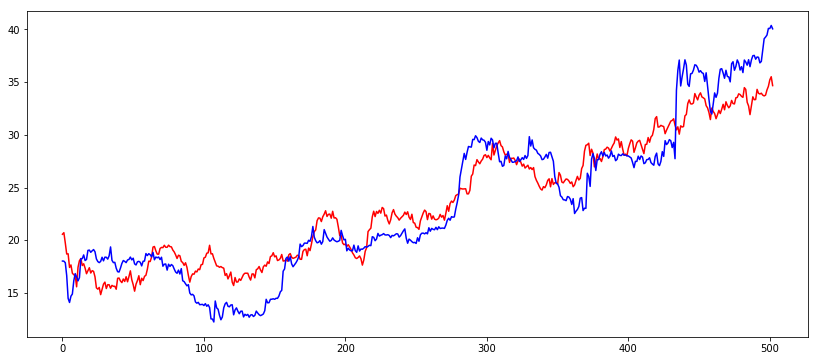

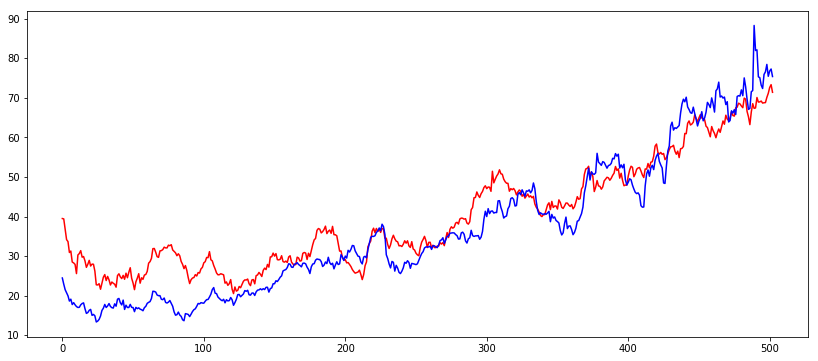

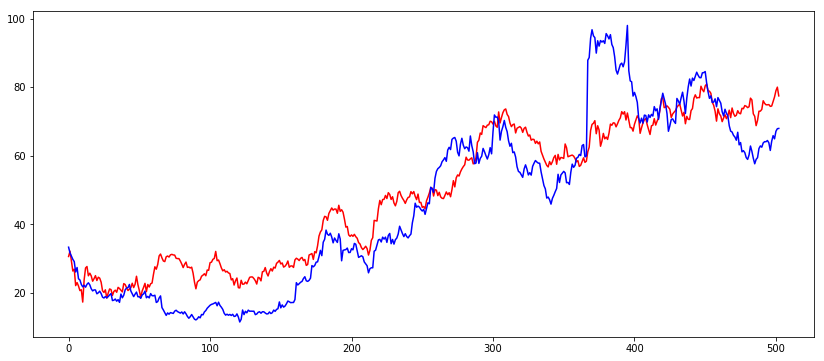

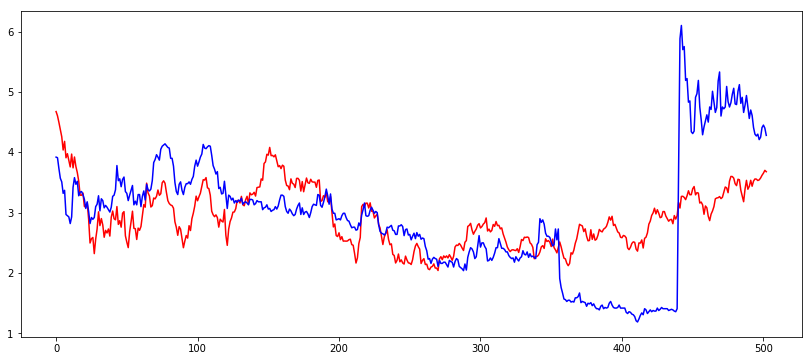

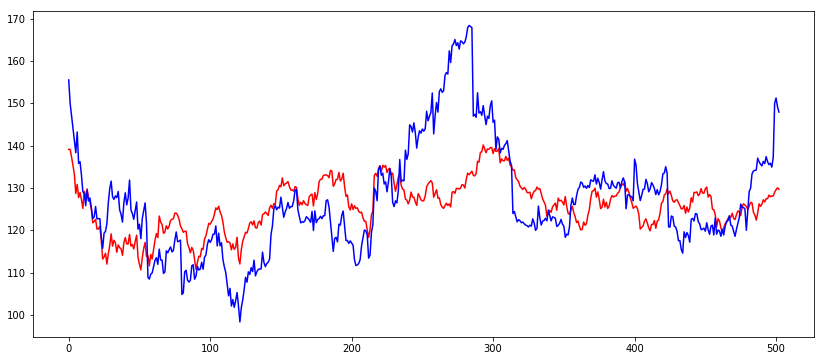

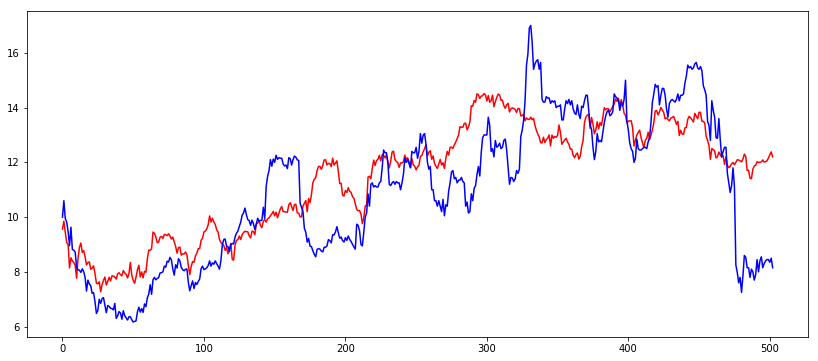

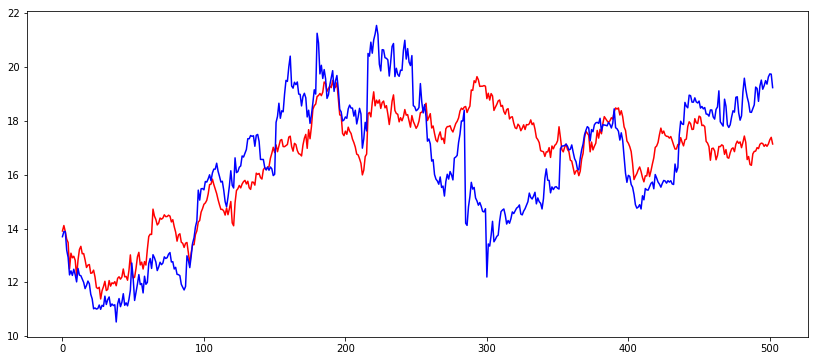

In [22]:
for j in unnormalized_p.keys():
    plt.figure()
    plt.plot(unnormalized_p[j] ,'r')
    plt.hold
    plt.plot(data[j] ,'b')
    plt.show;

# Re checking

In [23]:
diff = abs(p - batch_x)

In [24]:
for i in diff:
    print(i)

[ 0.18713311  0.21762214  0.20453273  0.25336552  0.23810536  0.15087482
  0.19831422  0.22884275  0.23833899  0.20933283  0.21630878  0.2015202
  0.14580033  0.18749498  0.13956983  0.10576248  0.12409573  0.07017298
  0.04049987  0.05862087  0.012515    0.0207148   0.07625501  0.05669046
  0.04048082  0.0562464   0.05763776  0.00819129  0.04104926  0.02682659
  0.05509551  0.02683042  0.00182128  0.00445694  0.0132868   0.00661663
  0.0006943   0.00883058  0.01496631  0.01709968  0.03773086  0.00199496
  0.01717308  0.01120134  0.00571979  0.01381988  0.05132117  0.04161335
  0.07449328  0.00932754  0.02809432  0.05279875  0.0307749   0.02340685
  0.01846261  0.02452886  0.07566012  0.14414961  0.1421138   0.16604955
  0.1426382   0.11707078  0.06893384  0.12851664  0.08393167  0.08381655
  0.10562495  0.15644839  0.14550001  0.1664382   0.20526694  0.17155702
  0.16103537  0.12379567  0.15027884  0.17533596  0.19803747  0.13783931
  0.18128582  0.22214144  0.23523482  0.24179599  0.

In [25]:
print('average error in our case = ',np.mean(diff))

average error in our case =  0.1115635678


In [26]:
random = np.random.uniform(0,1,(10,503))

In [27]:
diff_random = abs(batch_x - random)
print('average error in a random case = ',np.mean(diff_random))

average error in a random case =  0.322636978354


# Finding the commonals

In [1]:
sorted_by_value = []
for i in range(len(p)):
    sorted_by_value.append(np.mean(diff[i]))
    
listou = sorted(sorted_by_value)
print(listou)
baba = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
plt.bar(baba, listou);